In [1]:
import math
import numpy as np
from collections import Counter, defaultdict
import itertools
from functools import lru_cache
from itertools import chain, zip_longest
import pickle, random
from tqdm.notebook import tqdm
import copy
from glob import glob
from pprint import pprint
import gurobipy as gp
from gurobipy import GRB
from copy import deepcopy
import pickle as pck
from functools import cache
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

from utils import *

In [2]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')

title_font = 18
subplot_font = 14
plot_font = 14
legend_font = 14
fig_dpi = 300

ylim_pad_factor = 0.05

In [3]:
fwd_wksigma_to_dens = {}
for pck_file in glob("fwd/dens/*.pck"):
    with open(pck_file, 'rb') as pck_in:
        fwd_wksigma_to_dens.update(pck.load(pck_in))
print(len(fwd_wksigma_to_dens))
pprint(sorted((fwd_wksigma_to_dens.keys())))

53
[(2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 2),
 (2, 4, 3),
 (2, 5, 2),
 (2, 5, 3),
 (2, 5, 4),
 (2, 6, 2),
 (2, 7, 2),
 (2, 7, 3),
 (2, 8, 2),
 (2, 9, 2),
 (2, 10, 2),
 (2, 11, 2),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 2),
 (3, 3, 2),
 (3, 4, 2),
 (3, 4, 3),
 (3, 5, 2),
 (3, 6, 2),
 (3, 7, 2),
 (3, 10, 2),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 2),
 (4, 3, 2),
 (4, 4, 2),
 (4, 5, 2),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 2, 2),
 (5, 3, 2),
 (5, 6, 2),
 (6, 1, 2),
 (6, 1, 3),
 (7, 1, 2),
 (7, 1, 3),
 (8, 1, 2),
 (9, 1, 2),
 (10, 1, 2),
 (11, 1, 2)]


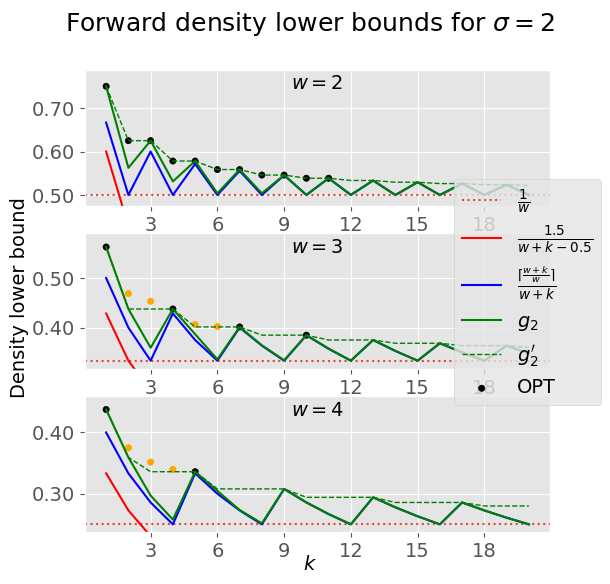

In [4]:

w_range = list(range(2, 5))
sigma=2
ax_width = int(len(w_range)**(1/2))
ax_height = math.ceil(len(w_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(6)

for idx, w in enumerate(w_range):
    k_range = list(range(1, 21))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    # ax = axs[int(idx / ax_width), idx % ax_width]
    ax = axs[idx // ax_width]
    ax.axhline(1/w, label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_2$", color="green")
    ax.plot(k_range, suff_bounded, label="$g_2^\prime$", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not math.isclose(aperiodic_bound_suff(w, k, sigma), fwd_wksigma_to_dens[(w, k, sigma)], rel_tol=(1 / (sigma**(w+k+1)))) else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=20)
    
    prop={'size': subplot_font}
    ax.set_title(f"$w={w}$", y=1.0, pad=-14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density lower bound", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds for $\sigma=2$", fontsize=title_font)
fig.savefig(f"../tex/media/bound-fwd-sigma2.png", dpi=fig_dpi)
fig.show()


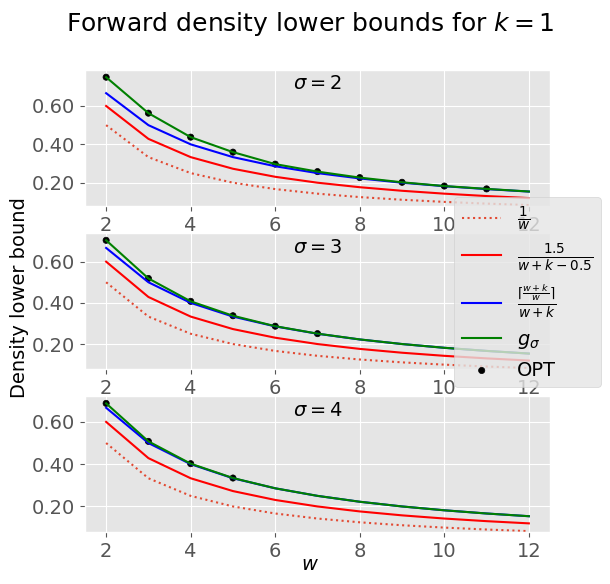

In [5]:

sigma_range = list(range(2, 5))
ax_width = int(len(sigma_range)**(1/2))
ax_height = math.ceil(len(sigma_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(6)

k=1
for idx, sigma in enumerate(sigma_range):
    w_range = list(range(2, 13))
    my_densities = [aperiodic_bound(w, k, sigma) for w in w_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for w in w_range]
    
    ax = axs[idx // ax_width]
    ax.plot(w_range, [1/w for w in w_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(w_range, [ragnar_WABI_LB(w, k) for w in w_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(w_range, [ragnar_ceil_LB(w, k) for w in w_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(w_range, my_densities, label="$g_\sigma$", color="green")
    opt_w = []
    opt_dens = []
    opt_color = []
    for w in w_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_w.append(w)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not math.isclose(aperiodic_bound_suff(w, k, sigma), fwd_wksigma_to_dens[(w, k, sigma)], rel_tol=(1 / (sigma**(w+k+1)))) else "black")

    ax.scatter(opt_w, opt_dens, label="OPT", color=opt_color, s=20)
    prop={'size': subplot_font}
    ax.set_title(f"$\sigma={sigma}$", y=1.0, pad=-14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$w$", y=.04, fontsize=plot_font)
fig.supylabel("Density lower bound", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds for $k=1$", fontsize=title_font)
fig.savefig(f"../tex/media/bound-fwd-k1.png", dpi=fig_dpi)
fig.show()


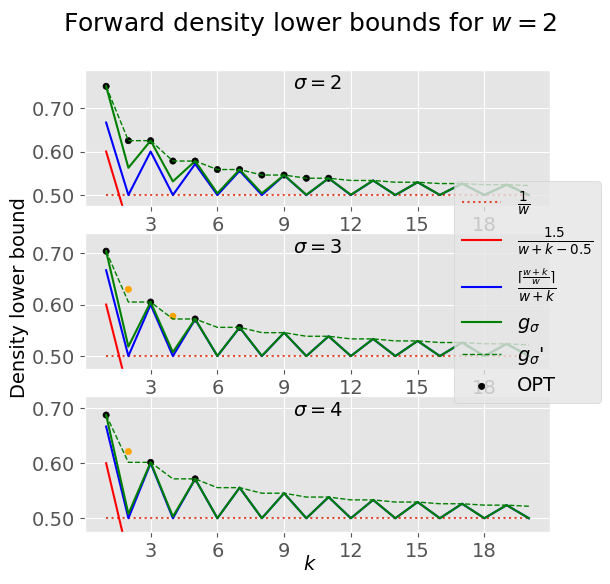

In [6]:

sigma_range = list(range(2, 5))
w=2
ax_width = int(len(sigma_range)**(1/2))
ax_height = math.ceil(len(sigma_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(6)

for idx, sigma in enumerate(sigma_range):
    k_range = list(range(1, 21))
    my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
    suff_bounded = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    ax = axs[idx // ax_width]
    ax.plot(k_range, [1/w for k in k_range], label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, [ragnar_WABI_LB(w, k) for k in k_range], label="$\\frac{1.5}{w+k-0.5}$", color="red")
    ax.plot(k_range, [ragnar_ceil_LB(w, k) for k in k_range], label="$\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", color="blue")
    ax.plot(k_range, my_densities, label="$g_\sigma$", color="green")
    ax.plot(k_range, suff_bounded, label="$g_\sigma$'", color="green", linestyle="--", linewidth=1)
    opt_k = []
    opt_dens = []
    opt_color = []
    for k in k_range:
        if (w, k, sigma) in fwd_wksigma_to_dens:
            opt_k.append(k)
            opt_dens.append(fwd_wksigma_to_dens[(w, k, sigma)])
            opt_color.append("orange" if not math.isclose(aperiodic_bound_suff(w, k, sigma), fwd_wksigma_to_dens[(w, k, sigma)], rel_tol=(1 / (sigma**(w+k+1)))) else "black")
    ax.scatter(opt_k, opt_dens, label="OPT", color=opt_color, s=20)
    prop={'size': subplot_font}
    
    ax.set_title(f"$\sigma={sigma}$", y=1.0, pad=-14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.04, fontsize=plot_font)
fig.supylabel("Density lower bound", x=0, fontsize=plot_font)
fig.suptitle("Forward density lower bounds for $w=2$", fontsize=title_font)
fig.savefig(f"../tex/media/bound-fwd-w2.png", dpi=fig_dpi)
fig.show()


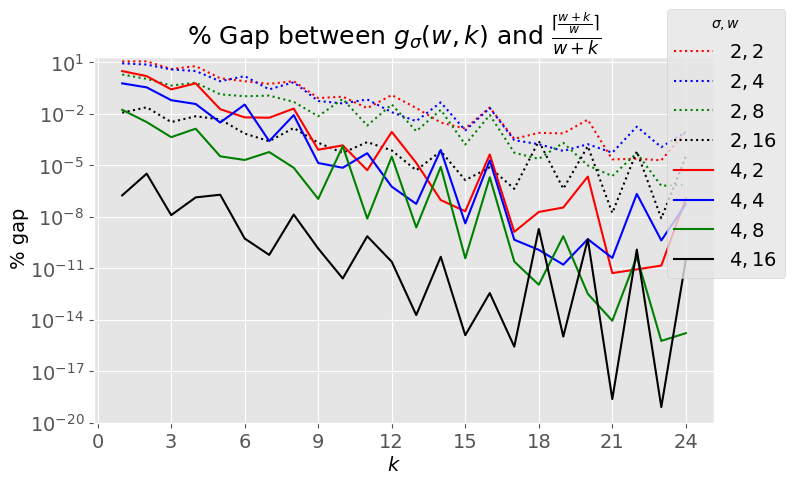

In [5]:

w_range = list([2, 4, 8, 16])
colors = ["red", "blue", "green", "black"]
ax_width = int(len(w_range)**(1/2))
ax_height = math.ceil(len(w_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, ax = plt.subplots()
fig.set_figheight(4.75)
fig.set_figwidth(8)

for sigma in (2, 4):
    for idx, w in enumerate(w_range):
        k_range = list(range(1, 25, 1))
        my_densities = [aperiodic_bound(w, k, sigma) for k in k_range]
        
        ax.plot(
            k_range, 
            [100*(aperiodic_bound(w, k, sigma) - (ragnar_ceil_LB(w, k))) / aperiodic_bound(w, k, sigma) for k in k_range], 
            label=f"${sigma}, {w}$", 
            color=colors[idx],
            linestyle="dotted" if sigma==2 else "solid")
        
        prop={'size': subplot_font}
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_ylim((1e-20, 20))
        ax.set_yscale("log")


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_font(prop)
handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', prop={'size': legend_font}, title="$\sigma, w$")
fig.supxlabel("$k$", y=0, fontsize=plot_font)
fig.supylabel("% gap", fontsize=plot_font)
fig.suptitle(f"% Gap between $g_\sigma(w,k)$" + " and $\\frac{\\lceil\\frac{w+k}{w}\\rceil}{w+k}$", fontsize=title_font)
fig.savefig(f"../tex/media/gap-sigma24.png", dpi=fig_dpi)
fig.show()


In [8]:
def aperiodic_bound(w, k, sigma=2, sketch_size=1):
    sampled = 0
    for d in divisors(w+k):
        primitive_n = aperiodic_necklaces(d, sigma)
        slack = math.ceil(sketch_size*d / w)
        sampled += primitive_n * slack
    return Fraction(sampled , (sigma ** (w+k)))

def aperiodic_bound_suff(w, k, sigma=2, sketch_size=1):
    ret = aperiodic_bound(w, k, sigma, sketch_size)
    if k % w != 1:
        ret = max(ret, aperiodic_bound(w, math.ceil(k/w)*w + 1, sigma, sketch_size))
    return ret
    

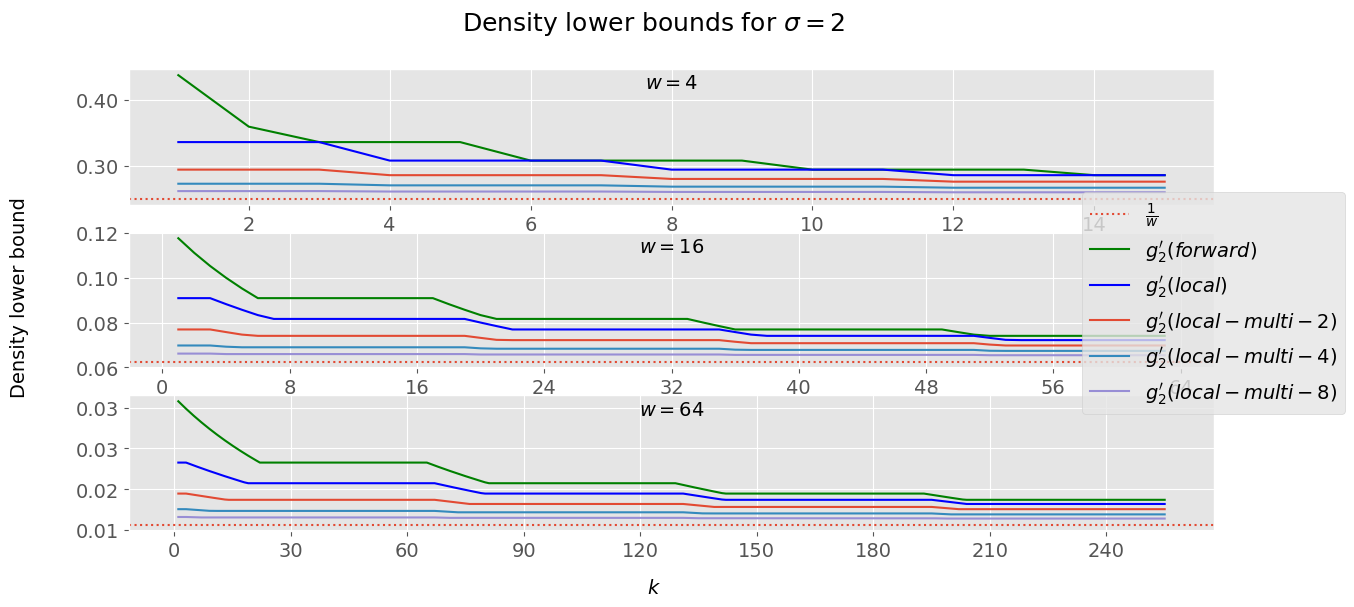

In [65]:
w_range = [4, 16, 64]
sigma=2
ax_width = int(len(w_range)**(1/2))
ax_height = math.ceil(len(w_range) / ax_width)
# ax_width, ax_height = ax_height, ax_width
fig, axs = plt.subplots(nrows=ax_height, ncols=ax_width)
fig.set_figheight(6)
fig.set_figwidth(14)

for idx, w in enumerate(w_range):
    ax = axs[idx // ax_width]
    
    k_range = list(range(1, 4*w))
    UHS_densities_fwd = [aperiodic_bound(w, k, sigma) for k in k_range]
    UHS_densities_fwd_prime = [aperiodic_bound_suff(w, k, sigma) for k in k_range]
    UHS_densities_local = [aperiodic_bound(w, k + w - 2, sigma) for k in k_range]
    UHS_densities_local_prime = [aperiodic_bound_suff(w, k + w - 2, sigma) for k in k_range]
    ax.axhline(1/w, label="$\\frac{1}{w}$", linestyle="dotted")
    ax.plot(k_range, UHS_densities_fwd_prime, label=f"$g_{sigma}^\prime (forward)$", color="green")
    ax.plot(k_range, UHS_densities_local_prime, label=f"$g_{sigma}^\prime (local)$", color="blue")

    # sketch_size sampled every w*sketch_size
    for sketch_size in [2, 4, 8]:
        augmented_w = w*sketch_size
        augmented_k_range = list(range(1, 2*max(k_range)))
        UHS_densities_multi = [aperiodic_bound(augmented_w, k + augmented_w - 2, sigma, sketch_size=sketch_size) for k in augmented_k_range]
        for idx in range(len(UHS_densities_multi)):
            UHS_densities_multi[idx] = float(max(UHS_densities_multi[idx:]))
        ax.plot(k_range, UHS_densities_multi[:len(k_range)], label=f"$g_{sigma}^\prime (local-multi-{sketch_size})$")
    
    
    
    prop={'size': subplot_font}
    ax.set_title(f"$w={w}$", y=1.0, pad=-14)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))\
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.00, fontsize=plot_font)
fig.supylabel("Density lower bound", x=0.04, fontsize=plot_font)
fig.suptitle(f"Density lower bounds for $\sigma={sigma}$", fontsize=title_font)
fig.savefig(f"../tex/media/bound-all-sigma2.png", dpi=fig_dpi)
fig.show()


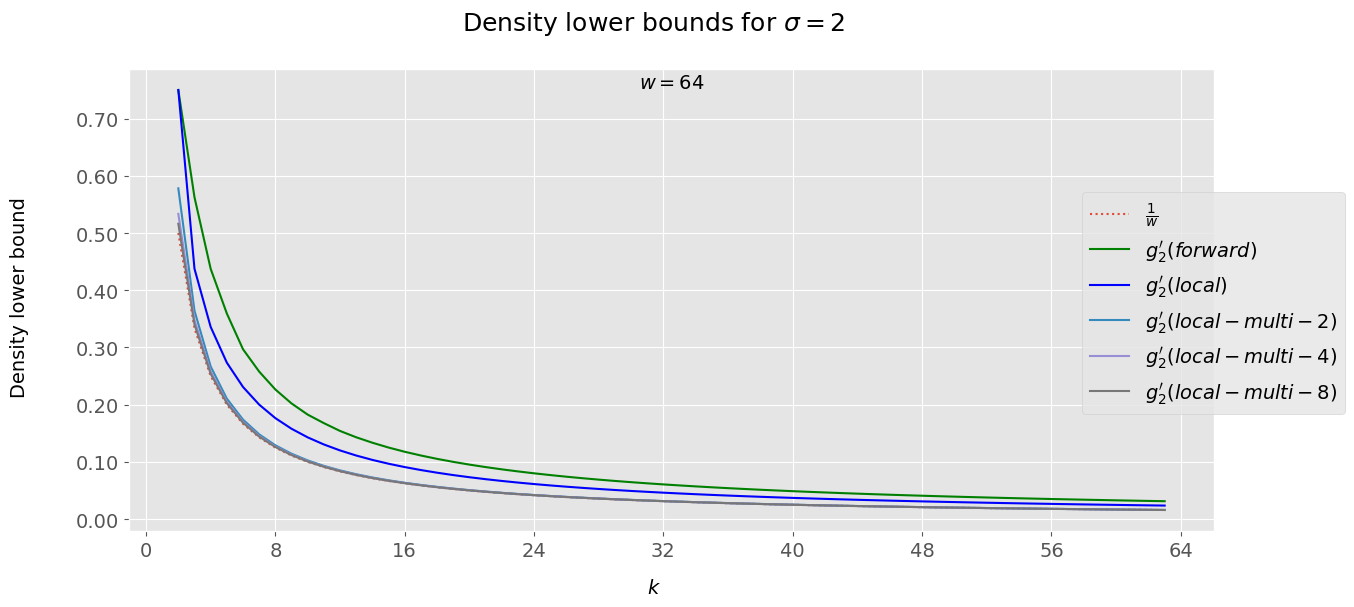

In [66]:

sigma=2
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(14)

 
w_range = list(range(2, 64))
k = 1

UHS_densities_fwd_prime = [aperiodic_bound_suff(w, k, sigma) for w in w_range]
UHS_densities_local_prime = [aperiodic_bound_suff(w, k + w - 2, sigma) for w in w_range]
ax.plot(w_range, [1/w for w in w_range], label="$\\frac{1}{w}$", linestyle="dotted")
ax.plot(w_range, UHS_densities_fwd_prime, label=f"$g_{sigma}^\prime (forward)$", color="green")
ax.plot(w_range, UHS_densities_local_prime, label=f"$g_{sigma}^\prime (local)$", color="blue")

# sketch_size sampled every w*sketch_size
for sketch_size in [2, 4, 8]:
    UHS_densities_multi = [aperiodic_bound(w*sketch_size, k + w*sketch_size - 2, sigma, sketch_size=sketch_size) for w in w_range]
    # for idx in range(len(UHS_densities_multi)):
    #     UHS_densities_multi[idx] = float(max(UHS_densities_multi[idx:]))
    ax.plot(w_range, UHS_densities_multi, label=f"$g_{sigma}^\prime (local-multi-{sketch_size})$")



prop={'size': subplot_font}
ax.set_title(f"$w={w}$", y=1.0, pad=-14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.set_ylim(((1-ylim_pad_factor)*(1/w), (1+ylim_pad_factor)*my_densities[0]))\
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
         ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_font(prop)


handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', prop={'size': legend_font})
fig.supxlabel("$k$", y=.00, fontsize=plot_font)
fig.supylabel("Density lower bound", x=0.04, fontsize=plot_font)
fig.suptitle(f"Density lower bounds for $\sigma={sigma}$", fontsize=title_font)
fig.savefig(f"../tex/media/bound-all-k1sigma2.png", dpi=fig_dpi)
fig.show()
